In [1]:
import torch as th
from diffusion.diffusion import FixedVarianceGaussianDiffusion, cosine_betas
from dataloaders import overfit_dataloader
from PIL import Image
import torchvision.transforms.functional as TVF

/home/vedant/miniconda3/envs/imagen/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def bytes_to_img(bytes):
    return ((bytes / 255) * 2) - 1

def img_to_bytes(img):
    return (((img + 1) / 2) * 255).to(th.uint8)

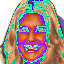

In [7]:
dl = overfit_dataloader(1, 1, "./data/parquetx64")
x_0_bytes_batch = next(iter(dl))
x_0 = bytes_to_img(x_0_bytes_batch)

x_0_pil = TVF.to_pil_image(x_0[0])
x_0_pil

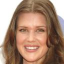

In [8]:
x_0_bytes_pil = TVF.to_pil_image(x_0_bytes_batch[0])
x_0_bytes_pil

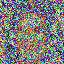

In [20]:
T = 1000
betas = cosine_betas(T)

diffusion = FixedVarianceGaussianDiffusion(betas)
x_0 = bytes_to_img(x_0_bytes_batch)
noise = th.rand_like(x_0)
t = th.Tensor([700]).to(th.long)
x_t = diffusion.q_sample(x_0, t=t, noise=noise)
x_t_pil = TVF.to_pil_image(x_t[0])
x_t_pil

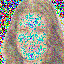

In [24]:
x_t_pil = TVF.to_pil_image(img_to_bytes(x_t[0]))
x_t_pil